## Welcome to exercise 04
앞서 배운 것을 바탕으로 실습을 해봅시다
1) ``SOS`` token을 넣어서 start letter를 넣지 않아도 생성하도록 바꿉시다<br>
2) ``RNN``코드를 ``nn.GRU``로 변경해봅시다<br>
3) 모델을 GPU로 돌려봅시다

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

## 데이터 준비

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 2 # EOS(end of sentence) / SOS(start of sentence) 기호 추가

def findFiles(path): return glob.glob(path)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []
for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Korean', 'Vietnamese', 'Portuguese', 'English', 'Dutch', 'Czech', 'Italian', 'Irish', 'German', 'Russian', 'Greek', 'Chinese', 'French', 'Spanish', 'Polish', 'Japanese', 'Arabic', 'Scottish']
O'Neal


## 네트워크 생성

이 네트워크는 지난 튜토리얼의 RNN 이 다른 입력들과 연결되는 category tensor를 추가 인자로 가지게 확장합니다. category tensor는 문자 입력과 마찬가지로 one-hot 벡터입니다.

역자주: 기존 입력과 category tensor를 결합하여 입력으로 사용하기 때문에 입력의 사이즈가 n_categories 만큼 커집니다.

우리는 출력을 다음 문자의 확률로 해석 합니다. 샘플링 할 때, 가장 확률이 높은 문자가 다음 입력 문자로 사용됩니다.

더 나은 동작을 위해 두 번째 선형 레이어 o2o (은닉과 출력을 결합한 후) 를 추가했습니다 . 또한 Drop-out 계층이 있습니다. 이 계층은 주어진 확률(여기서는 0.1)로 무작위로 입력을 0 # 으로 만듭니다. 일반적으로 입력을 흐리게 해서 과적합을 막는 데 사용됩니다. 여기서 우리는 고의로 일부 혼돈을 추가하고 샘플링 다양성을 높이기 위해 네트워크의 마지막에 이것을 사용합니다.

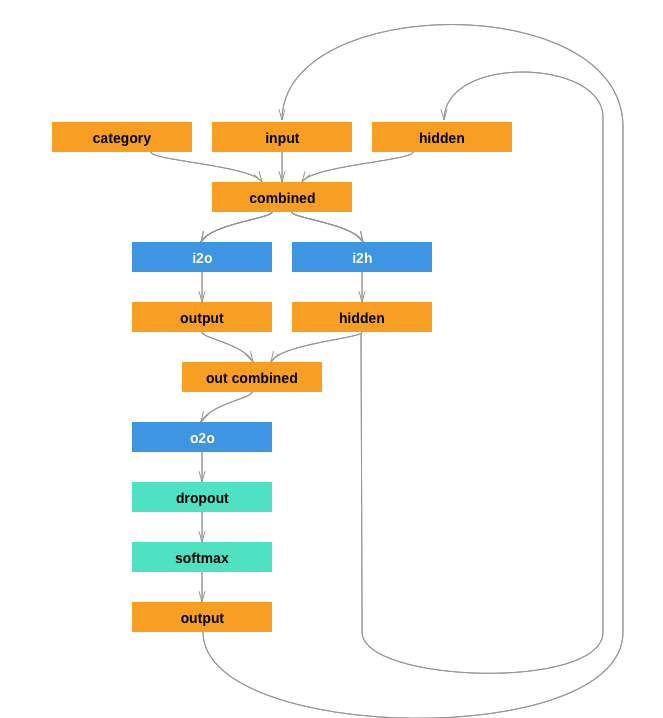

# 1) ``<SOS>`` token 추가하기

In [3]:
import torch
from torch import nn

In [4]:
import random

# 목록에서 무작위 아이템 반환
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 임의의 category 및 그 category에서 무작위 줄(이름) 얻기
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [5]:
len(all_letters)

58

In [6]:
n_letters

60

In [7]:
# Category를 위한 One-hot 벡터
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 입력을 위한 처음(SOS)부터 마지막 문자(EOS 제외)까지의  One-hot 행렬
def inputTensor(line):
    tensor = torch.zeros(len(line) + 1, 1, n_letters)
    # len(line) + 1 : number of line + <SOS> token
    # 1 : batch size
    # n_letters + 1 : n_letters 
    tensor[0][0][n_letters - 1] = 1 # n_letters - 1-> SOS
    for li in range(0, len(line)):
        letter = line[li]
        tensor[li+1][0][all_letters.find(letter)] = 1
    return tensor

# 목표를 위한 처음 문자(SOS 제외)부터 마지막(EOS) 까지의 LongTensor
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(len(line))]
    letter_indexes.append(n_letters - 2) # n_letters - 2 -> EOS
    return torch.LongTensor(letter_indexes)

In [8]:
categoryTensor('Korean')

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
targetTensor('hello')

tensor([ 7,  4, 11, 11, 14, 58])

In [10]:
# 임의의 Category에서 Category, Input, Target Tensor를 만듭니다.
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [11]:
category, input, target = randomTrainingExample()
category.shape, input.shape, target.shape

(torch.Size([1, 18]), torch.Size([5, 1, 60]), torch.Size([5]))

In [12]:
target.shape

torch.Size([5])

## 네트워크 학습

마지막 출력만 사용하는 분류와 달리, 모든 단계에서 예측을 수행하므로 모든 단계에서 손실을 계산합니다.<br>
Autograd의 마법이 각 단계의 손실들을 간단하게 합하고 마지막에 역전파를 호출하게 해줍니다.

In [17]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size 
        self.i2h = nn.Linear(category_size + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(category_size + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(output_size + hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.LogSoftmax(dim=1) 
        
    def forward(self, category, input, hidden):
        combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        out_combined = torch.cat((hidden, output), 1)
        output = self.o2o(out_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)        

In [18]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
#         print(output.shape)
#         print(target_line_tensor[i].shape)
#         break
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [19]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
category_size = n_categories
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # plot_every 마다 초기화

In [197]:
start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

KeyboardInterrupt: 

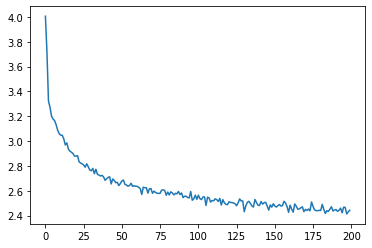

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## 네트워크 샘플링

샘플링을 위해서, 네트워크에 하나의 글자를 주고 다음 문자를 물어보고 이것을 다음 문자로 전달하는 것을 EOS 토큰까지 반복합니다.

    입력 카테고리(언어), 시작 문자, 비어 있는 은닉 상태를 위한 Tensor를 생성하십시오
    시작 문자로 output_name 문자열을 생성하십시오
    최대 출력 길이까지,
        현재 문자를 네트워크에 전달하십시오.
        가장 높은 출력에서 다음 문자와 다음 은닉 상태를 얻으십시오
        만일 문자가 EOS면, 여기서 멈추십시오
        만일 일반적인 문자라면, output_name 에 추가하고 계속하십시오
    마지막 이름을 반환하십시오

In [21]:
max_length = 20

# 카테고리와 시작 문자로 부터 샘플링 하기
def sample(category):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor('#') # 마지막이 SOS여서 find가 못찾으면 -1을 뱉기 때문에 아무글자나 넣어도됨
        hidden = rnn.initHidden()

        output_name = ''

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 2: # n_letters - 2 : 'EOS' token
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category):
    print(sample(category))

samples('Russian')
print('-'*10)
samples('German')
print('-'*10)
samples('Spanish')
print('-'*10)
samples('Chinese')

wwwiwwiiwiiiiiiiiwii
----------
StPPPPPPPPPPtPPtPPPP
----------
RSSSSSSSwSSSSSSSSSSS
----------
RPPPPPPPPPPPPP PPPPP


In [22]:
samples('Korean')

tttttttSttStttwttttt


## 2. ``nn.GRU``로 바꿔보기

$$r_t​=σ(W_{ir}​x_t​+b_{ir}​+W_{hr}​h_{(t−1)}​+b_{hr}​)\\z_{t}​=σ(W_{iz}​x_{t}​+b_{iz}​+W_{hz}​h_{(t−1)}​+b_{hz}​)\\n_{t}​=tanh(W_{in}​x_{t}​+b_{in}​+r_{t}​∗(W_{hn}​h_{(t−1)}​+b_{hn}​))\\h_t​=(1−z_t​)∗n_t​+z_t​∗h_{(t−1)}​​$$
<b>class</b> nn.GRU(input_size, hidden_size, num_layers)<br>
<b>inputs</b> input, h_0
- <b>input</b> of shape (seq_len, batch, input_size)
- <b>h_0</b> of shape(num_layers*num_directions, batch, hidden_size)<br>

         

<b>Outputs</b>: output, h_n

- <b>output</b> of shape (seq_len, batch, num_directions * hidden_size)
- <b>h_n</b> of shape (num_layers * num_directions, batch, hidden_size)



In [23]:
from torch.utils.data import Dataset, DataLoader

### dataset 정의

In [24]:
class NameDataset(Dataset):
    def __init__(self, data_input, data_category, 
                 transform_input=None, transform_target=None, transform_category=None):
        self.data_input = data_input 
        self.data_category = data_category 
        self.transform_input = transform_input 
        self.transform_target = transform_target
        self.transform_category = transform_category

    def __len__(self):
        return len(self.data_input)
    
    def __getitem__(self, idx):
        sample_data = self.data_input[idx]
        sample_category = self.data_category[idx]
        if self.transform_input: # input에 대한 전처리 -> <SOS>부터 <EOS> 미포함 마지막 Tensor
            sample_input = self.transform_input(sample_data)
        if self.transform_target: # target에 대한 전처리 -> <SOS>미포함 첫 텐서부터 <EOS>까지
            sample_target = self.transform_target(sample_data)
        if self.transform_category:h_n
            sample_category = self.transform_category(sample_category)
        return sample_category, sample_input, sample_target    

In [25]:
category_list = []
name_list = []
for category, name in category_lines.items():
    for n in name:
        category_list.append(category)
        name_list.append(n)

In [27]:
name_ds = NameDataset(name_list, category_list,
            transform_input=inputTensor, 
            transform_target=targetTensor, 
            transform_category=categoryTensor)

In [28]:
for cat, inp, tgt in name_ds:
    print(cat.shape)
    print(inp.shape)
    print(tgt.shape)
    break

torch.Size([1, 18])
torch.Size([4, 1, 60])
torch.Size([4])


### DataLoader 정의

In [29]:
name_dl = DataLoader(name_ds, 1)

In [45]:
for cat, inp, tar in name_dl.dataset:
    print(cat.shape, inp.shape, tar.shape)
    break

torch.Size([1, 18]) torch.Size([4, 1, 60]) torch.Size([4])


In [48]:
inp.shape

torch.Size([4, 1, 60])

### GRU network정의 

In [427]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size 
        self.gru = nn.GRU(category_size + input_size + hidden_size, hidden_size)
        # nn.GRU는 output size를 받지 않고, 
        # output의 dim은 (seq_len, batch, num_directions*hidden_size) 이다
        # ouput 결과를 별도의 레이어로 원하는 결과로 나오도록 짜야 함.
        self.o2o = nn.Linear(hidden_size + hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.LogSoftmax(dim=1) 
        
    def forward(self, category, input, hidden):
#         print(category.shape, input.shape, hidden.shape)
        combined = torch.cat((category, input, hidden), 1)
        combined.unsqueeze_(0)
        output, hidden = self.gru(combined)
        out_combined = torch.cat((hidden, output), 2)
        output = self.o2o(out_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        output = output[0]
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)        

In [428]:
category_size = n_categories
rnn = GRU(n_letters, 128, n_letters)
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # plot_every 마다 초기화

start = time.time()

In [429]:
n_hidden = 128
rnn = GRU(n_letters, n_hidden, n_letters)
h0 = rnn.initHidden()
category = categoryTensor('Korean')
input = inputTensor('c')
print(category.shape, input.shape, h0.shape)
output, next_hidden = rnn(category, input[0], h0)
output[0]

torch.Size([1, 18]) torch.Size([2, 1, 60]) torch.Size([1, 128])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SelectBackward>)

In [430]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        hidden = hidden.squeeze(1)
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        output = output.squeeze(1)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [432]:
for iter in range(1, n_iters + 1):
    for category, input, target in name_dl.dataset:
        output, loss = train(category, input, target)
        total_loss += loss

        if iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

        if iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0

KeyboardInterrupt: 

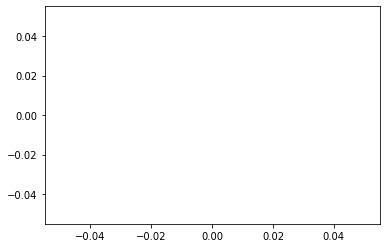

In [422]:
plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20

# 카테고리와 시작 문자로 부터 샘플링 하기
def sample(category):
    with torch.no_grad():  # 샘플링에서 히스토리를 추적할 필요 없음
        category_tensor = categoryTensor(category)
        input = inputTensor('#') # 마지막이 SOS여서 find가 못찾으면 -1을 뱉기 때문에 아무글자나 넣어도됨
        hidden = rnn.initHidden()

        output_name = ''

        for i in range(max_length):
            output, hidden = gru(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 2: # n_letters - 2 : 'EOS' token
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# 하나의 카테고리와 여러 시작 문자들로 여러 개의 샘플 얻기
def samples(category):
    print(sample(category))

samples('Russian')
print('-'*10)
samples('German')
print('-'*10)
samples('Spanish')
print('-'*10)
samples('Chinese')

## 3. GPU로 돌려보기

In [433]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [434]:
rnn.to(device)

GRU(
  (gru): GRU(206, 128)
  (o2o): Linear(in_features=256, out_features=60, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        hidden = hidden.squeeze(1)
        output, hidden = rnn(category_tensor.to(device), input_line_tensor[i].to(device), hidden.to(device))
        output = output.squeeze(1)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)